Ophalen programma's en data
Voeg wel nog de juiste filenaam in


In [144]:
# %matplotlib widget #requires package ipympl installed, for interactive plots.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.gridspec as gridspec
np.set_printoptions(precision=4,threshold =9,suppress=True)  #Compact display of arrays.

# Voeg de juiste file naam in
path = '2023-12-01 - 12.18.mqa'


df=pd.read_csv(path, sep='\t',header=0)



Time = df['Time'].str.replace(',', '.').astype(float).to_list()
Xpos = df['Point #1.X'].str.replace(',', '.').astype(float).to_list()
Ypos = df['Point #1.Y'].str.replace(',', '.').astype(float).to_list()


t = [Time[i] for i in range(len(Time)) if str(Xpos[i]) !='nan' ]
Xpos = [x for x in Xpos if str(x) != 'nan']
Ypos = [x for x in Ypos if str(x) != 'nan']


# Er moet nog een juiste scaling factor komen voor de afstand per pixel
t =np.asarray(t[1:69]) 
x = np.asarray(Xpos[1:69])
y = np.asarray(Ypos[1:69])
print(len(t), len(x))



68 68


Test plot

Fit maken van de functie om de golf te laten oscileren door x-as

Pas wel de p0 de hele tijd aan bij elke keer proberen te fitten

In [145]:
from scipy.optimize import curve_fit

df.drop([x for x in range(50)])
def sinus_model(t,x0,A,omega,phi):
    return x0+A*np.sin(omega*t+phi)

popt, pcov = curve_fit(sinus_model,t,x,p0=[1326.00 ,-10 ,15.62,6.28],bounds = ([0,-100,0,0],[1500,100,100,2*np.pi]))
x = np.asarray(x) - popt[0]
x = np.asarray(x)*11.186/abs(popt[1])/100
y = np.asarray(y)*11.186/abs(popt[1])/100
popt, pcov = curve_fit(sinus_model,t,x,p0=[0,-0.11,13.62,6.28],bounds = ([-10,-50,-50,0],[10,50,50,2*np.pi]))
parameter=['Offset (m)', 'Amplitude (m)', 'Frequency (rad/s)', 'phase (rad)']


for i in range (4):
    print("The optimal value for ", parameter[i], 'is:', "{:.2f}".format(popt[i]), '\u00B1', "{:.5f}".format(np.sqrt(pcov[i,i])))

The optimal value for  Offset (m) is: -0.02 ± 0.00222
The optimal value for  Amplitude (m) is: 0.28 ± 0.00311
The optimal value for  Frequency (rad/s) is: 15.78 ± 0.06627
The optimal value for  phase (rad) is: 4.42 ± 0.02432


Check of de verschuiving goed is gegaan

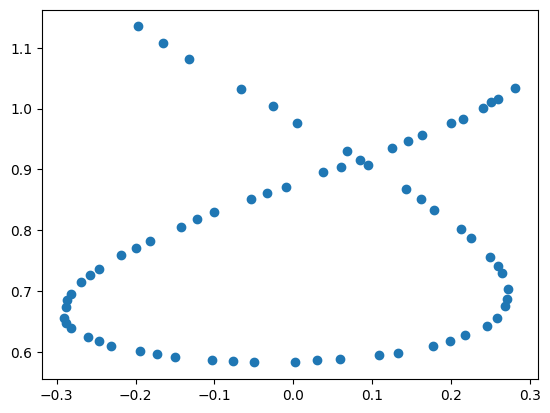

In [146]:
plt.scatter(x,y)

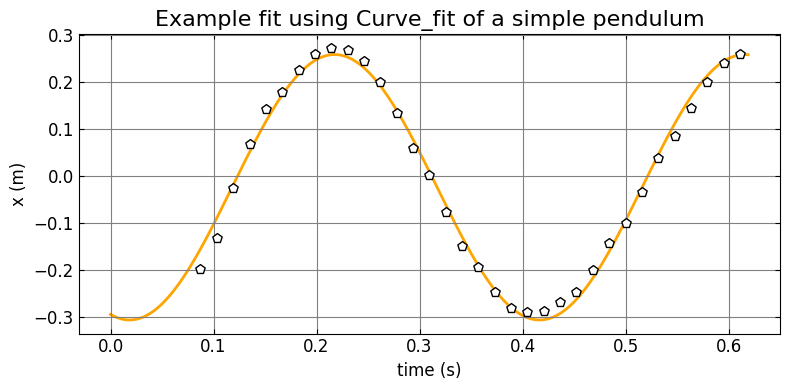

In [147]:
xfit = np.linspace(0,max(t),1000) #create new data for fit.

#Plot data + fit

fig,axes=plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
axes.plot(xfit,sinus_model(xfit,*popt), color ='orange', lw = 2,zorder =1) #plot fit
axes.scatter(t[::2],x[::2] ,color = 'black', s = 50, marker ='p',ec='black',fc='white',zorder=2) #plot every 15th datapoint 

#plot axis labels and limits
axes.set_title('Example fit using Curve_fit of a simple pendulum',fontsize=16)
axes.set_xlabel('time (s)',fontsize=12)
axes.set_ylabel('x (m)',fontsize=12)
# axes.set_xlim(0.5, max(t)+0.2)
# axes.set_ylim(np.min(x)-0.1,np.max(x)+0.1)

#Some plot settings
axes.tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
axes.grid(True,color='gray')
plt.tight_layout() #creates optimal padding levels for figure (especially usefull for side-by-side figures)

# location='Path' #Path to your prefered location, e.g. User/Downloads/
# plt.savefig(location+'simple_pendulum.svg') #Extension can be .png/.jpg/.etc or .svg/.pdf (Vector Image)

plt.show()

x coordinaat omschrijven naar phi met amplitude (A)

Zorg dat x/A niet boven 1 en onder -1 kan komen

In [148]:
# minimum of maximum, afhankelijk van welke groter is. Als de fit erg goed is kan ook die A gebruikt worden.
phi = np.asarray(x)/abs(min(x))

phi = np.asarray(np.arccos(phi))
phi_sum = []
delta_sum = 0
for i in range(len(phi)):
    delta_sum += abs(phi[i] - phi[i-1])
    phi_sum.append(delta_sum)

Fit phi speed

Plot fit phi speed

Moet nog beter

The optimal value for  a is: 14.05 ± 0.08160
The optimal value for  b is: 1.00 ± 0.03150


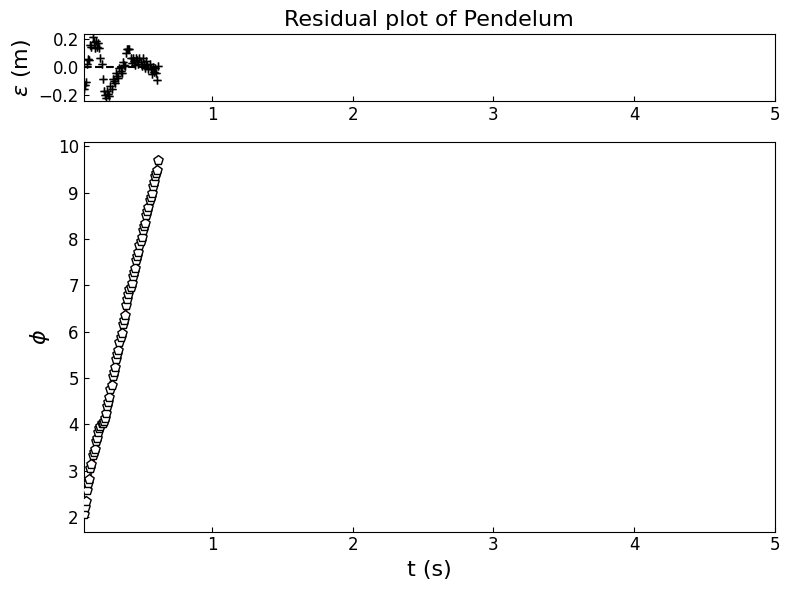

In [149]:
def phi_model(t,a,b):
    return a*t + b

popt_phi, pcov_phi = curve_fit(phi_model,t,phi_sum,p0=[11.57,1.87],bounds = ([-100,-10],[100,100]))

parameter_phi = ['a', 'b']
for i in range (2):
    print("The optimal value for ", parameter_phi[i], 'is:', "{:.2f}".format(popt_phi[i]), '\u00B1', "{:.5f}".format(np.sqrt(pcov_phi[i,i])))

r_c = 0.11186
r_b = 21.98/1000
r= r_c - r_b 
speed_phi = r*popt_phi[0]
fout_speed_phi = np.sqrt(pcov_phi[0,0])




fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(5, 4) #Creates a grid of 6 rows and 4 columns.
axes_main = plt.subplot(gs[1:5, :4]) #Main axis goes from row 1 to 6.
axes_residuals = plt.subplot(gs[0, :4],sharex=axes_main) #Residual axis is row 0.

axes_main.tick_params(axis='both',direction ='in',labelsize=12)
axes_main.scatter(t[::1],phi_sum[::1],color='black', marker = 'p',ec='black',fc='white',s=50,zorder=3)
axes_main.plot(t,phi_model(t,*popt_phi),color='darkred',ls='--', lw=2)
axes_main.set_xlabel('t (s)',fontsize=16)
axes_main.set_ylabel('$\phi$',fontsize=16)
axes_main.set_xlim(np.min(t),5)

axes_residuals.tick_params(axis='both',direction ='in',labelsize=12)
axes_residuals.set_title('Residual plot of Pendelum',fontsize=16)
axes_residuals.errorbar(t,phi_sum-phi_model(t,*popt_phi),xerr=0,yerr=0,fmt='none',
                        color='black',ecolor='black',capsize=3)
axes_residuals.hlines(0,np.min(t),np.max(t),color='black',ls='--')
axes_residuals.set_ylabel(r'$\epsilon$ (m)',fontsize=16)
axes_residuals.set_xlim(np.min(t),5)

plt.tight_layout()
plt.show()
plt.close()

The optimal value for  a is: 13.79 ± 0.41856
The optimal value for  b is: 1.04 ± 0.06666
The optimal value for  c is: -0.03 ± 0.04227


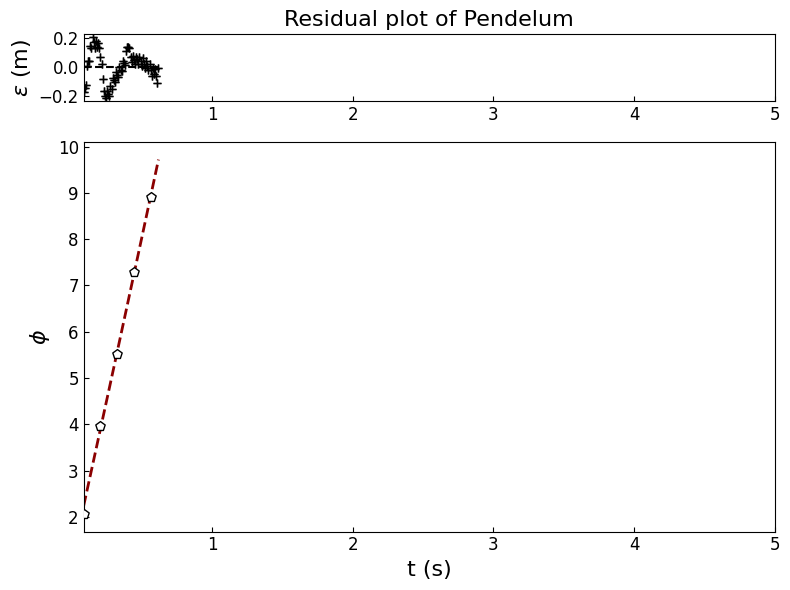

In [150]:
def phi_demping_model(t,a,b,c):
    return a*t*np.exp(-c*t) + b

popt_phi_demping, pcov_phi_demping = curve_fit(phi_demping_model,t,phi_sum,p0=[17.8,-5.58,0.08],bounds = ([-100,-10,-1],[100,100,5]))

parameter_phi_demping = ['a', 'b', 'c']
for i in range (3):
    print("The optimal value for ", parameter_phi_demping[i], 'is:', "{:.2f}".format(popt_phi_demping[i]), '\u00B1', "{:.5f}".format(np.sqrt(pcov_phi_demping[i,i])))

fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(5, 4) #Creates a grid of 6 rows and 4 columns.
axes_main = plt.subplot(gs[1:5, :4]) #Main axis goes from row 1 to 6.
axes_residuals = plt.subplot(gs[0, :4],sharex=axes_main) #Residual axis is row 0.

axes_main.tick_params(axis='both',direction ='in',labelsize=12)
axes_main.scatter(t[::15],phi_sum[::15],color='black', marker = 'p',ec='black',fc='white',s=50,zorder=3)
axes_main.plot(t,phi_demping_model(t,*popt_phi_demping),color='darkred',ls='--', lw=2)
axes_main.set_xlabel('t (s)',fontsize=16)
axes_main.set_ylabel('$\phi$',fontsize=16)
axes_main.set_xlim(np.min(t),5)

axes_residuals.tick_params(axis='both',direction ='in',labelsize=12)
axes_residuals.set_title('Residual plot of Pendelum',fontsize=16)
axes_residuals.errorbar(t,phi_sum-phi_demping_model(t,*popt_phi_demping),xerr=0,yerr=0,fmt='none',
                        color='black',ecolor='black',capsize=3)
axes_residuals.hlines(0,np.min(t),np.max(t),color='black',ls='--')
axes_residuals.set_ylabel(r'$\epsilon$ (m)',fontsize=16)
axes_residuals.set_xlim(np.min(t),5)

plt.tight_layout()
plt.show()
plt.close()

Fit z

The optimal value for  x0 is: 0.85 ± 0.02225
The optimal value for  V is: 9.40 ± 0.15171
The optimal value for  A is: 0.44 ± 0.03536
The optimal value for  a is: 1.49 ± 0.23923
The optimal value for  b is: -0.00 ± 0.07159


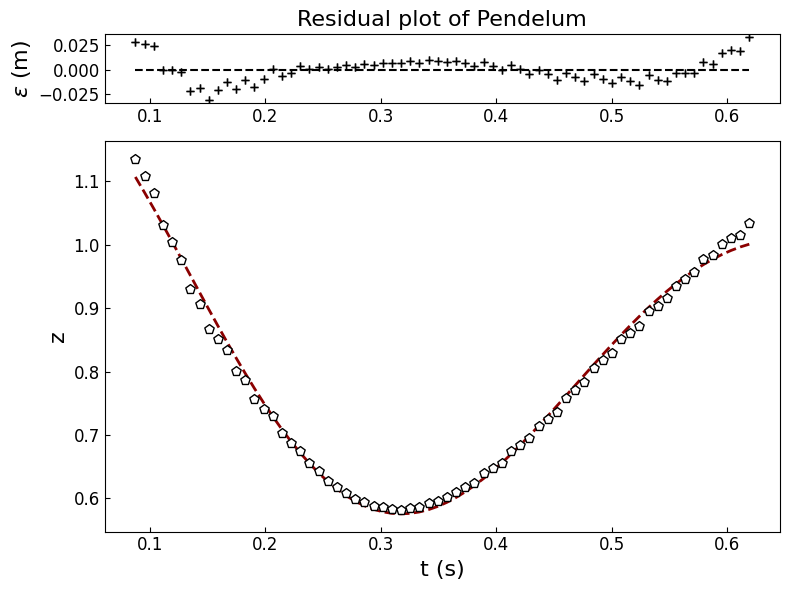

In [151]:
xfit = np.linspace(0,max(t),1000) #create new data for fit.

def z_model(t,x0,V,A,a,b):
    return A*np.exp(-a*t) * np.cos(V*t)+b*t+x0

popt_z, pcov_z = curve_fit(z_model,t,y,p0=[1.00, 15,1,0.8 ,-0.56],bounds = ([0,0,0,0,-5],[40,200,100,10,0]))

parameter=['x0','V', 'A','a','b']
for i in range (5):
    print("The optimal value for ", parameter[i], 'is:', "{:.2f}".format(popt_z[i]), '\u00B1', "{:.5f}".format(np.sqrt(pcov_z[i,i])))

fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(5, 4) #Creates a grid of 6 rows and 4 columns.
axes_main = plt.subplot(gs[1:5, :4]) #Main axis goes from row 1 to 6.
axes_residuals = plt.subplot(gs[0, :4],sharex=axes_main) #Residual axis is row 0.

axes_main.tick_params(axis='both',direction ='in',labelsize=12)
axes_main.scatter(t[::1],y[::1],color='black', marker = 'p',ec='black',fc='white',s=50,zorder=3)
axes_main.plot(t,z_model(t,*popt_z),color='darkred',ls='--', lw=2)
axes_main.set_xlabel('t (s)',fontsize=16)
axes_main.set_ylabel('z',fontsize=16)
# axes_main.set_xlim(np.min(t),5)

axes_residuals.tick_params(axis='both',direction ='in',labelsize=12)
axes_residuals.set_title('Residual plot of Pendelum',fontsize=16)
axes_residuals.errorbar(t,y-z_model(t,*popt_z),xerr=0,yerr=0,fmt='none',
                        color='black',ecolor='black',capsize=3)
axes_residuals.hlines(0,np.min(t),np.max(t),color='black',ls='--')
axes_residuals.set_ylabel(r'$\epsilon$ (m)',fontsize=16)
# axes_residuals.set_xlim(np.min(t),5)

plt.tight_layout()
plt.show()
plt.close()

Snelheid in z richting berekenen

In [152]:
speed_z = -popt_z[2]*popt_z[3] +popt_z[4]


fout_speed_z = np.sqrt(pcov_z[2,2] + pcov_z[3,3])+ pcov_z[4,4]
print(fout_speed_z)
print(speed_z, '\u00B1', fout_speed_z)

# beginsnelheid
v_0 = np.sqrt((speed_phi)**2 + (speed_z)**2)
fout_v_0 = np.sqrt(fout_speed_phi**2 + fout_speed_z**2)
print(v_0,'\u00B1', fout_v_0)


0.24695158812082785
-0.64906760592595 ± 0.24695158812082785
1.4201571773738693 ± 0.2600839182854852


Energie

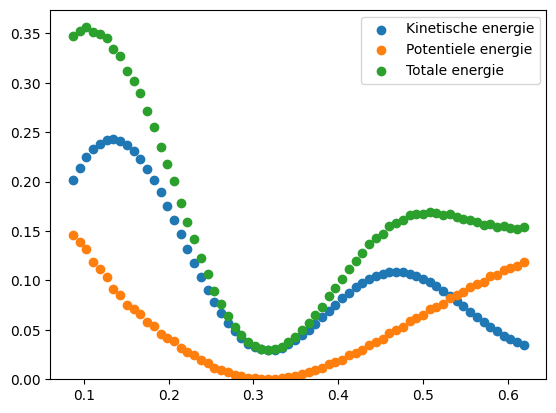

In [153]:
m=26.9/1000
g = 9.81
r_c = 0.11186
r_b = 21.98/1000
r= r_c - r_b

E_h = m*g*np.asarray(y[0:15000])
E_h = np.asarray(E_h)-min(E_h)

v_phi_2= (r*popt_phi_demping[0]*np.exp(-popt_phi_demping[2]*np.asarray(t)))**2 
v_z_2 = (-popt_z[2]*popt_z[3]*np.exp(-popt_z[3]*np.asarray(t))*np.cos(popt_z[1]*np.asarray(t))-popt_z[2]*popt_z[1]*np.exp(-popt_z[3]*np.asarray(t))*np.sin(popt_z[1]*np.asarray(t)) +popt_z[4])**2
v_2 =  v_phi_2  + np.asarray(v_z_2)
E_k = m*np.asarray(v_2)*7/10

L = np.asarray(E_k - E_h)
E_tot = np.asarray(E_k + E_h)

plt.scatter(t,E_k)
plt.scatter(t,E_h)
plt.scatter(t,E_tot)
plt.legend(['Kinetische energie', 'Potentiele energie', 'Totale energie'])
# plt.xlim(0)
plt.ylim(0)

plt.show()